In [1]:
import os
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from utils import pairwise_distances, segpath2path, point2segments
from analysis_by_plot import myttests, myboxplot, draw_floorplan

In [2]:
import matplotlib.transforms as mtransforms

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 7.5
plt.rcParams['axes.titlesize'] = 7.5

figw2 = 3.307
figw1 = 6.85


def complete_figure(fig, axes, index):    
    trans = mtransforms.ScaledTranslation(0.02, -0.02, fig.dpi_scale_trans)
    for label, ax in zip(index, axes.flatten()):
        ax.text(0.0, 1.0, '({})'.format(label), transform=ax.transAxes + trans,
                verticalalignment='top', fontfamily='Arial')

In [3]:
n_trial = 100
n_epoch_train, n_epoch_test = 120, 500
goal_idx = -1  # does not change too much
ls_model = 'pure-pursuit', 'visual-localisor', 'lamb'
ls_model_keys = ls_model
ls_model_name = 'pure-pursuit', 'visual-localisor', 'differential-MB'
ls_color = 'tab:green', 'tab:orange', 'tab:red'
n_model = len(ls_model)

ls_value = 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, #20, 50
n_condition = len(ls_value)
catchment_radius = 0.372 / 2 ## 0.372 is the wheel axle length of Freight

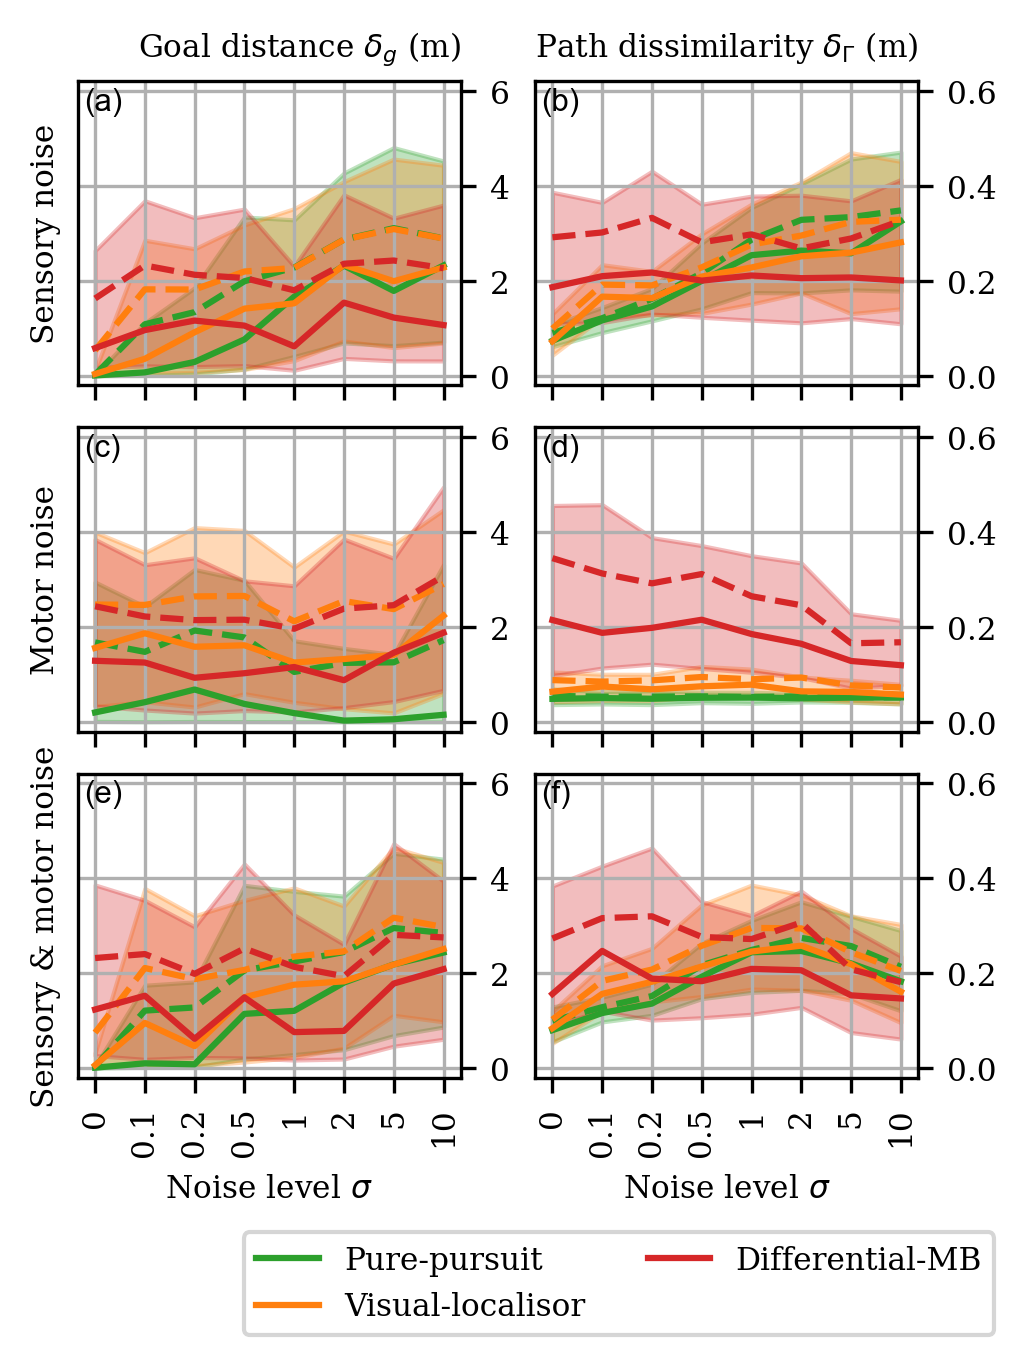

In [29]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey='col', figsize=(figw2, 4), dpi=300, layout='constrained')


for axcol, datafile_randomroute in zip(axes, ['sensor_noisefreetrain_robustness_3in1_randomroute.npy',
                                                 'motor_robustness_3in1_randomroute.npy',
                                                 'noise_noisefreetrain_robustness_3in1_randomroute.npy']):
    data_randomroute = np.load(os.path.join('records/data_randomroute', datafile_randomroute), allow_pickle=True)[()]
    bx, cx = axcol

    for xoffset, model_name, color in zip(np.arange(n_model) - n_model / 2 + 0.5, ls_model_name, ls_color):        
        area_success, min_dist2goal, dsim_test2train, n_reach = [data_randomroute[key][model_name] for key in ('area_success', 'min_dist2goal', 'dsim_test2train', 'noise1_reach')]

        for bc, data in zip((bx, cx), (min_dist2goal, dsim_test2train)):
            quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
            avg = np.nanmean(data, axis=1)
            bc.plot(np.arange(n_condition), avg, color=color, ls='dashed')
            bc.plot(np.arange(n_condition), quant[1], color=color)
            bc.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)
            

for ax in axes.flatten():
    ax.grid()
    ax.set_xticks(np.arange(n_condition), [])
    ax.yaxis.tick_right()
    
    
for ax in axes[-1]:
    ax.set_xlabel(r'Noise level $\sigma$')
    ax.set_xticklabels(ls_value, rotation=90)

            
for ax, tt in zip(axes.T[0], ('Sensory noise', 'Motor noise', 'Sensory & motor noise')):
    ax.set_ylabel(tt)
    
for ax, yl in zip(axes[0], ('Goal distance $\delta_g$ (m)', 'Path dissimilarity $\delta_\Gamma$ (m)')):
    ax.set_title(yl, loc='right')
    
axes[0, 0].set_ylim(-0.2, 6.2)
axes[0, 1].set_ylim(-0.02, 0.62)

for model_name, color in zip(['Pure-pursuit', 'Visual-localisor', 'Differential-MB'], ls_color):
    axes[-1, 0].plot([], [], color=color, label=model_name)
fig.legend(ncol=2, loc='upper right', bbox_to_anchor=(1, 0))

complete_figure(fig, axes, 'abcdef')

# one set data

In [28]:
# record_dir = 'sensor_learn_robustness_3in1_randomroute'  # sensor noise in vision and vector 
# record_dir = 'sensor_noisefreetrain_robustness_3in1_randomroute'  #### no sensor noise in learning
# record_dir = 'sensory_robustness_3in1_randomroute'  # only visual noise but no vector noise in learning # nice result
# var_name = 'noise_sensor'

# record_dir = 'motor_learn_robustness_3in1_randomroute'  # noise in vector memory too
# record_dir = 'motor_robustness_3in1_randomroute'  #### no noise in vector memory 
# var_name = 'noise_motor' 

record_dir = 'noise_noisefreetrain_robustness_3in1_randomroute'  #### nice result
# record_dir = 'noise_noisefreetrain_robustness_3in1_randomroute_noobj'  ####
var_name = 'noise'


# 'motor_robustness_3in1_randomexplore': training route is randomly generated by random walk, not shortest path


In [7]:
data_path = np.load(os.path.join('records', record_dir, 'data_path.npy'), allow_pickle=True)[()]

In [8]:
data_dist_test2goal, data_min_dist2goal, data_time_min_dist2goal = {}, {}, {}
data_dist_testtrunc2goal = {}
data_time_catchment = {}
data_test_cp_ratio = {}
data_dist_init2goal = {}

for model_name in ls_model_name:
    path_train_init = data_path[model_name]['train'][:n_condition, :, :, 0]
    path_train_goal = data_path[model_name]['train'][:n_condition, :, :, -1]
    dist_init2goal = np.linalg.norm(path_train_goal - path_train_init, axis=-1)
    dist_test2goal = np.linalg.norm(path_train_goal[:, :, :, np.newaxis] - data_path[model_name]['test'][:n_condition], axis=2)
    time_min_dist2goal = np.argmin(dist_test2goal, axis=2)
    min_dist2goal = np.min(dist_test2goal, axis=2)
    
    data_dist_test2goal[model_name] = dist_test2goal
    data_min_dist2goal[model_name] = min_dist2goal
    data_time_min_dist2goal[model_name] = time_min_dist2goal
    
    nan_mask = (time_min_dist2goal.T < np.tile(np.arange(n_epoch_test), (n_condition, n_trial, 1)).T).T
    nan_mask_path = np.moveaxis(np.tile(nan_mask, (2, 1, 1, 1)), 0, 2)
    data_dist_testtrunc2goal[model_name] = np.where(nan_mask, np.nan, dist_test2goal)
    data_path[model_name]['test_trunc'] = np.where(nan_mask_path, np.nan, data_path[model_name]['test'][:n_condition])

    time_catchment = np.argmax(dist_test2goal <= catchment_radius, axis=-1)
    data_time_catchment[model_name] = np.where(time_catchment == 0, np.nan, time_catchment)
    
    # test collision, proximity
    data_test_cp_ratio[model_name] = {}
    for cp in 'cp':
        key_cp = 'test_{}'.format(cp)
        test_cp_trunc = np.where(nan_mask, 0, data_path[model_name][key_cp][:n_condition])
#         data_test_cp_ratio[model_name][key_cp] = np.count_nonzero(test_cp_trunc, axis=-1) / (time_min_dist2goal + 1)
        data_test_cp_ratio[model_name][key_cp] = np.count_nonzero(test_cp_trunc, axis=-1)
    
    data_dist_init2goal = dist_init2goal

In [9]:
data_dsim_test2train, data_dist_test2path = {}, {}

for model_name in ls_model_name:
    model_dsim_test2train, model_dist_test2path = [], []
    for path_train_val, path_test_val, time_mindist_test2goal_val in zip(data_path[model_name]['train'], 
                                                                          data_path[model_name]['test_trunc'],
                                                                          data_time_min_dist2goal[model_name]):
        val_time_mindist = []
        val_dist_test2path = np.full((n_trial, n_epoch_test), np.nan)
        for trial_idx, (path_train_trial, path_test_trial, time_mindist) in enumerate(zip(path_train_val, 
                                                                                        path_test_val, 
                                                                                        time_mindist_test2goal_val)):
            dsim_test2train, dist_test2path = segpath2path(path_test_trial.T[:time_mindist + 1], path_train_trial.T)
            val_time_mindist.append(dsim_test2train)
            val_dist_test2path[trial_idx, :time_mindist + 1] = dist_test2path
        model_dsim_test2train.append(val_time_mindist)
        model_dist_test2path.append(val_dist_test2path)
        
    data_dsim_test2train[model_name] = np.array(model_dsim_test2train)
    data_dist_test2path[model_name] = np.array(model_dist_test2path)
#################### dsim

Text(0.5, 0, 'percentage (%)')

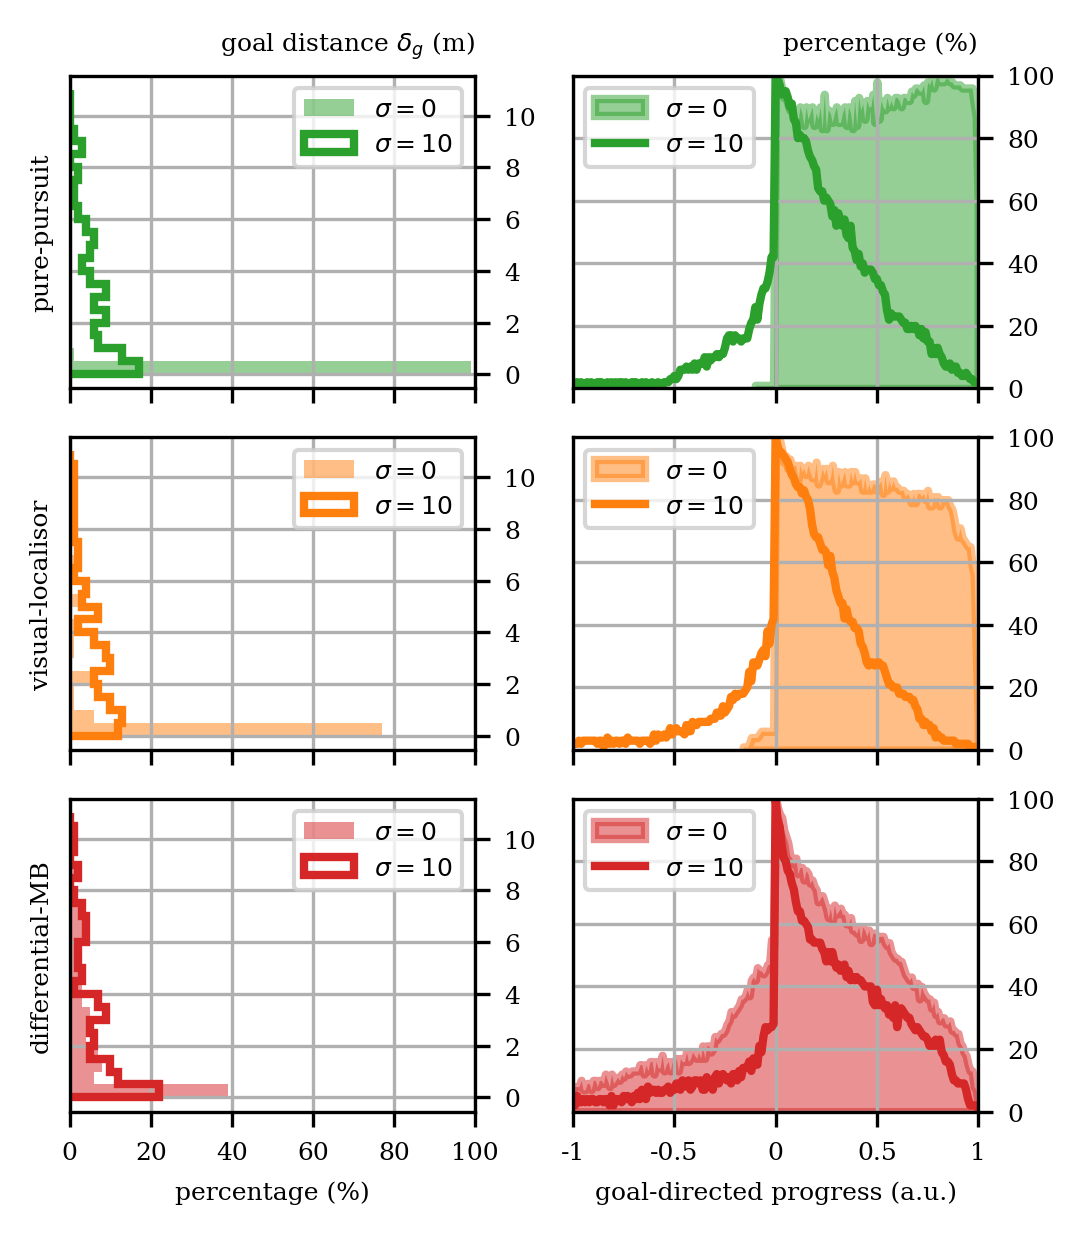

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(3.5, 4), dpi=300, sharey='col', layout='constrained')

for model_name, color, axcol in zip(ls_model_name, ls_color, axes):
    for vidx, ht, ls, al in zip([0, -1], ('stepfilled', 'step'), ('solid', 'dotted'), (0.5, 1)):
        noise = ls_value[vidx]
        label = r'$\sigma={}$'.format(noise)
        data = data_min_dist2goal[model_name][vidx]
        axcol[0].hist(data, label=label,
            bins=22, #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], #200, 
            range=(0, 11),
            color=color, orientation='horizontal', histtype=ht, alpha=al, lw=2)        
      
        ###
        dist_test2goal, dist_test2path = data_dist_test2goal[model_name][vidx], data_dist_test2path[model_name][vidx]
        progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100)
        progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)

        val_test2path, val_n_point = [], []
        val_ptime = []
        for trial_progress, trial_test2path in zip(progress, dist_test2path):
            px, pxidx, pxinv = np.unique(trial_progress, return_index=True, return_inverse=True)
            pxinvsort = np.argsort(pxinv)
            t2p_interp = np.interp(progress_step, pxinv[pxinvsort], trial_test2path[pxinvsort])#, left=np.nan, right=np.nan)
            val_test2path.append(t2p_interp)
            val_n_point.extend(px)

            ptime = np.full_like(progress_step, np.nan)
            ptime[(px[~np.isnan(px)] - np.min(progress_step)).astype(int)] = pxidx[~np.isnan(px)]
            val_ptime.append(ptime)


        p_reach, n_reach = np.unique(val_n_point, return_counts=True)
        if vidx == 0:
            axcol[1].fill_between(p_reach, n_reach, color=color, label=label, lw=2, alpha=al)
        else:
            axcol[1].plot(p_reach, n_reach, color=color, label=label, alpha=al, lw=2)
            
    
for ax, model, xlim in zip(axes.T[0], ls_model_name, (105, 84, 42)):
    ax.legend(loc=1, fontsize=6)
    ax.set_ylabel(model, fontsize=6)
    ax.set_yticks([0, 2, 4, 6, 8, 10])
    ax.set_xlim(right=100)
    
for ax in axes.T[1]:
    ax.set_ylim(0, 100)
    ax.set_xlim(-100, 100)
    ax.legend(loc=2, fontsize=6)
    ax.set_xticks(np.arange(-100, 101, 50), [-1, -0.5, 0, 0.5, 1])
    
for ax in axes.flatten():
    ax.grid()
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
    ax.yaxis.tick_right()
    
for ax in axes[:-1].flatten():
    ax.set_xticklabels([])
    
axes[0, 0].set_title('goal distance $\delta_g$ (m)', fontsize=6, loc='right')
axes[-1, 1].set_xlabel('goal-directed progress (a.u.)', fontsize=6)
axes[0, 1].set_title('percentage (%)', fontsize=6, loc='right')
axes[-1, 0].set_xlabel('percentage (%)', fontsize=6)

Text(1.0, 1.0, 'path dissimilarity $\\delta_\\Gamma$ (m)')

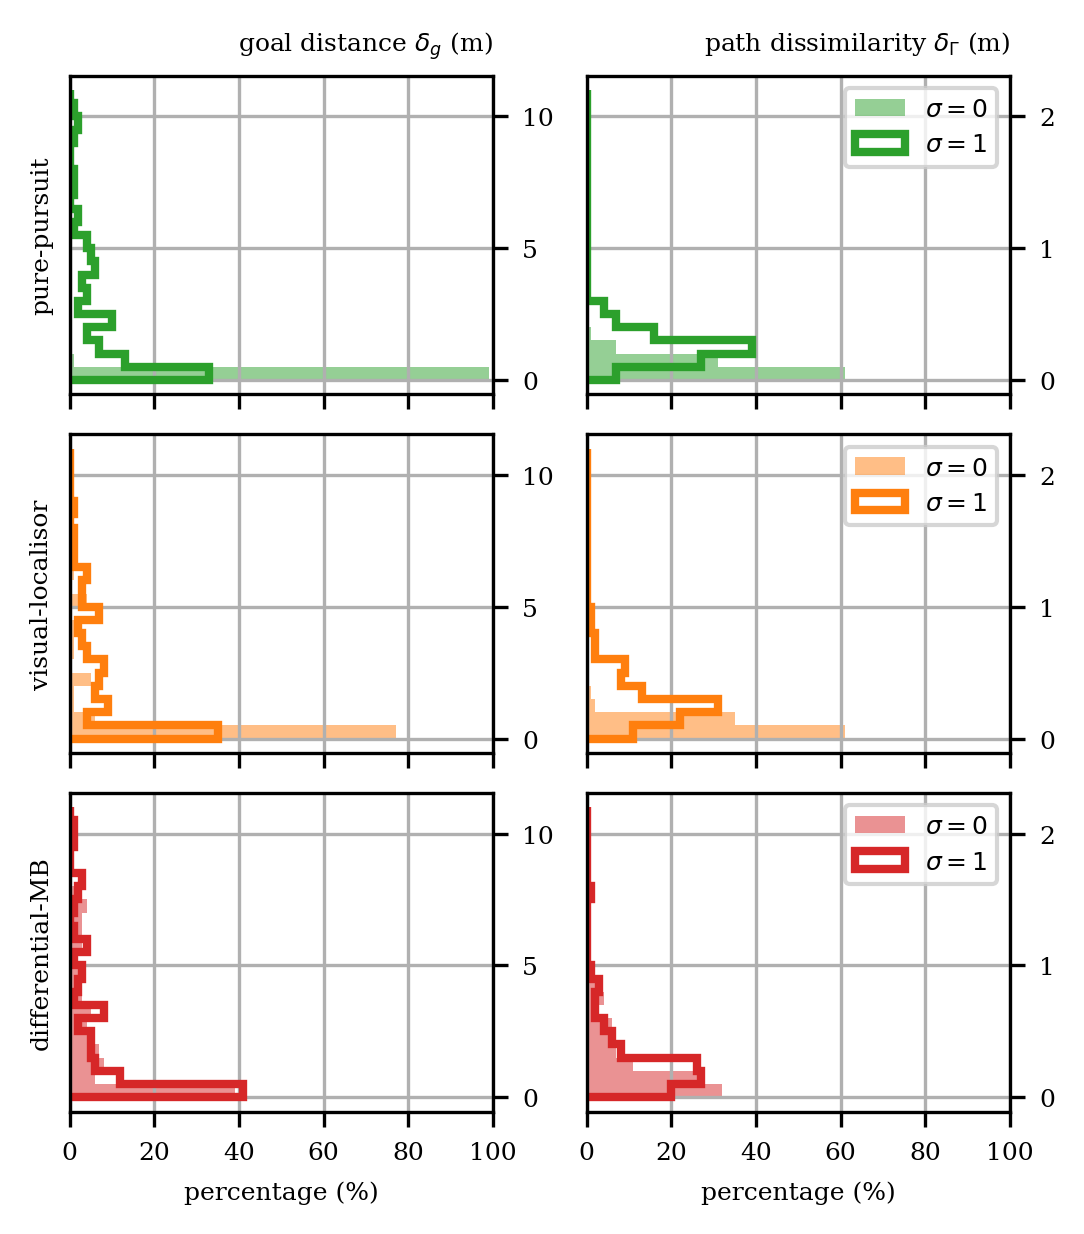

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(3.5, 4), dpi=300, sharey='col', sharex='col', layout='constrained')

for model_name, color, axcol in zip(ls_model_name, ls_color, axes):
    for vidx, ht, ls, al in zip([0, 4], ('stepfilled', 'step'), ('solid', 'dotted'), (0.5, 1)):
        noise = ls_value[vidx]
        label = r'$\sigma={}$'.format(noise)
        data = data_min_dist2goal[model_name][vidx]
        axcol[0].hist(data, label=label,
            bins=22, #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], #200, 
            range=(0, 11),
            color=color, orientation='horizontal', histtype=ht, alpha=al, lw=2) 
        
        dsim = data_dsim_test2train[model_name][vidx]
        axcol[1].hist(dsim, label=label,
            bins=22, #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], #200, 
            range=(0, 2.2),
            color=color, orientation='horizontal', histtype=ht, alpha=al, lw=2) 
            
    
for ax, model in zip(axes.T[0], ls_model_name):
    ax.set_yticks([0, 5, 10])
    ax.set_ylabel(model, fontsize=6)
    
for ax in axes.T[1]:
    ax.set_yticks([0, 1, 2])
    ax.legend(loc=1, fontsize=6)
    
    
for ax in axes.flatten():
    ax.grid()
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
    ax.yaxis.tick_right()
    ax.set_xlim(right=100)
    
for ax in axes[-1].flatten():
    ax.set_xlabel('percentage (%)', fontsize=6)
    
axes[0, 0].set_title('goal distance $\delta_g$ (m)', fontsize=6, loc='right')
axes[0, 1].set_title('path dissimilarity $\delta_\Gamma$ (m)', fontsize=6, loc='right')


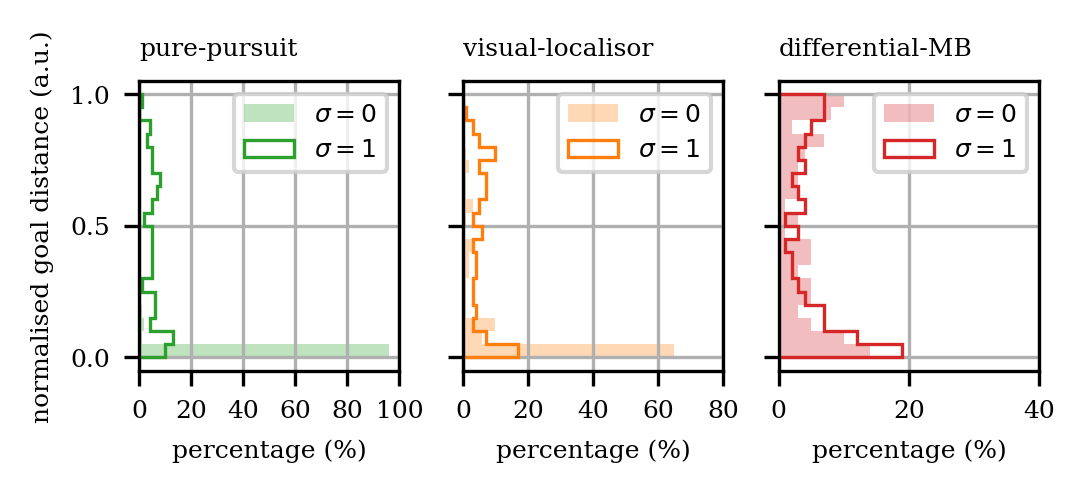

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(3.5, 1.5), dpi=300, sharey=True, layout='constrained')

for model_name, color, ax in zip(ls_model_name, ls_color, axes):
    for vidx, ht, ls, al in zip([0, 4], ('stepfilled', 'step'), ('solid', 'solid'), (0.3, 1)):
        noise = ls_value[vidx]
        label = r'$\sigma={}$'.format(noise)
        
        normindist = np.divide(data_min_dist2goal[model_name][vidx], data_dist_test2goal[model_name][vidx][:, 0])
        ax.hist(normindist, label=label,
            bins=20, #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], #200, 
            range=(0, 1),
            color=color, orientation='horizontal', histtype=ht, alpha=al, lw=0.8) 
            
            
    ax.set_title(model_name, fontsize=6, loc='left')

    
    
for ax in axes.flatten():
    ax.grid()
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
#     ax.yaxis.tick_right()
    ax.legend(loc=1, fontsize=6)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel('percentage (%)', fontsize=6)
    

#     ax.set_xlim(right=100)
    
# for ax in axes[-1].flatten():
    
# axes[0, 0].set_title('goal distance $\delta_g$ (m)', fontsize=6, loc='right')
axes[0].set_ylabel('normalised goal distance (a.u.)', fontsize=6)

axes[0].set_xlim(right=100)
axes[1].set_xlim(right=80)
axes[2].set_xlim(right=40)

axes[0].set_xticks(np.linspace(0, 100, 6))
axes[1].set_xticks(np.linspace(0, 80, 5))

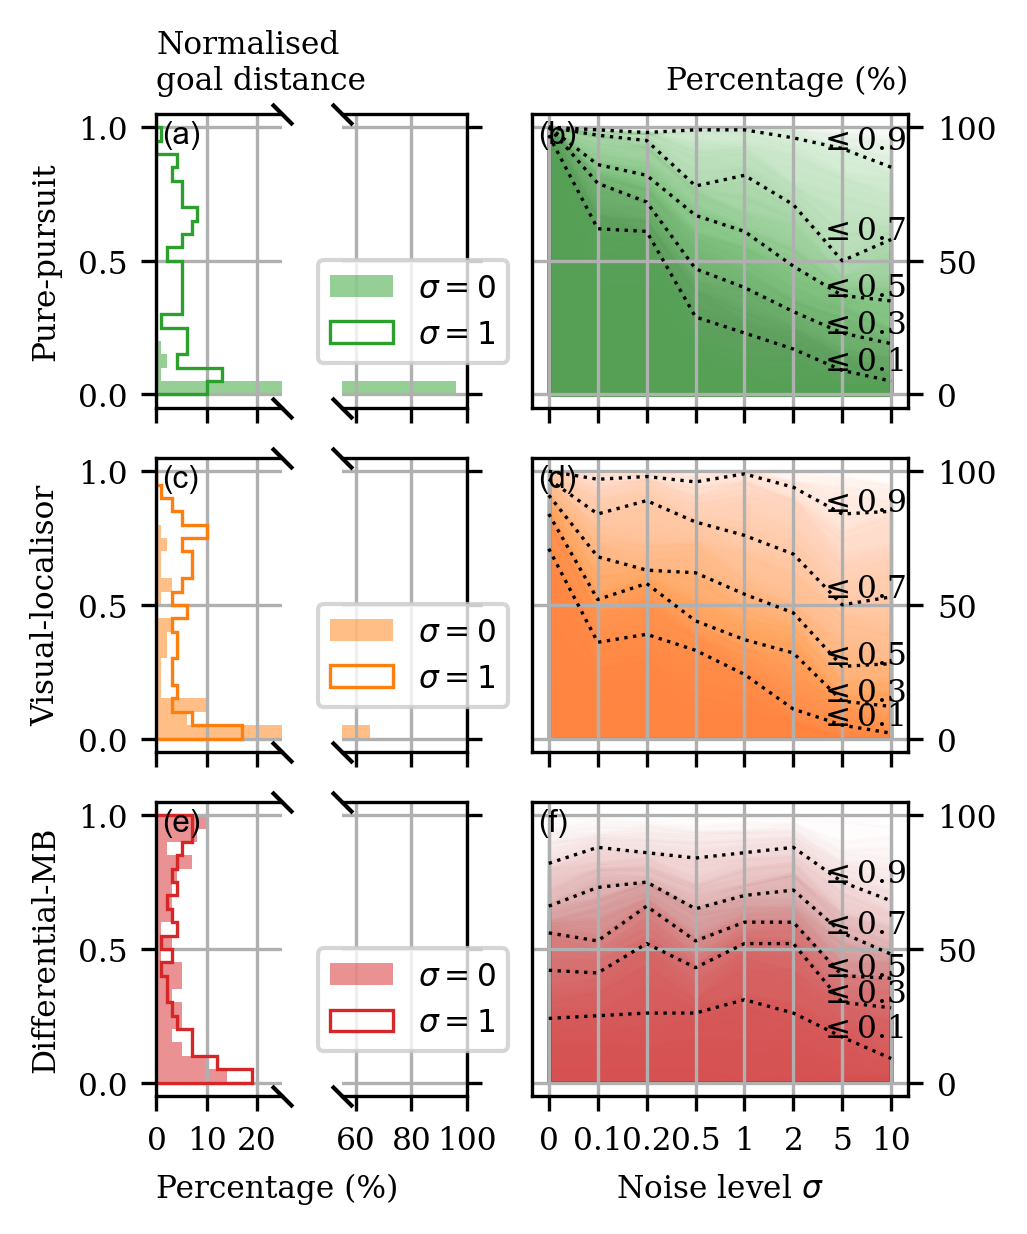

In [47]:
fig, axs = plt.subplot_mosaic('''
                                aAbbb
                                cCddd
                                eEfff
                                ''', figsize=(figw2, 4), dpi=300, layout='constrained')

lw = 0.8
for akl, akb1, akb2, model_name, color in zip('bdf', 'ace', 'ACE', ls_model_name, ls_color):
    ax = axs[akl]
    data = data_min_dist2goal[model_name]
    for progress in np.arange(0, 1.01, 0.01):
        half = np.count_nonzero(data <= dist_init2goal * progress, axis=1)
        ax.fill_between(np.arange(n_condition), 0, half, color=color, alpha=0.01)
    for progress in (.1, .3, .5, .7, .9):
        half = np.count_nonzero(data <= dist_init2goal * progress, axis=1)
        ax.plot(half, c='k', ls='dotted', lw=lw)
        ax.text(n_condition - 2.5
                , np.max(half[-2:]) + .01, '$\leq${}'.format(progress))
    
    ax.set_xticks(np.arange(n_condition), ls_value)


    for vidx, ht, ls, al in zip([0, 4], ('stepfilled', 'step'), ('solid', 'solid'), (0.5, 1)):
        noise = ls_value[vidx]
        label = r'$\sigma={}$'.format(noise)
        
        normindist = np.divide(data_min_dist2goal[model_name][vidx], data_dist_test2goal[model_name][vidx][:, 0])
        for akb in (akb1, akb2):
            axs[akb].hist(normindist, label=label, bins=20, range=(0, 1),
                            color=color, orientation='horizontal', histtype=ht, alpha=al, lw=lw) 

    axs[akb1].set_xlim(0, 25)
    axs[akb1].set_xticks((0, 10, 20))
    axs[akb2].set_xlim(55, 100)
    axs[akb2].set_xticks((60, 80, 100))
    axs[akb2].legend(loc=3, bbox_to_anchor=(-0.315, 0.1))
            
    # hide the spines between ax and ax2
    axs[akb2].spines.left.set_visible(False)
    axs[akb1].spines.right.set_visible(False)
    axs[akb2].yaxis.tick_right()
#     axs[akb1].set_yticklabels([])
    
    d = -1  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axs[akb2].plot([0, 0], [1, 0], transform=axs[akb2].transAxes, **kwargs)
    axs[akb1].plot([1, 1], [0, 1], transform=axs[akb1].transAxes, **kwargs)
        
        
for akb1, model_name in zip('ace', ['Pure-pursuit', 'Visual-localisor', 'Differential-MB']):
    axs[akb1].set_ylabel(model_name)
        
for ak in 'ce':
    axs[ak].sharey(axs['a'])

axs['e'].set_xlabel('Percentage (%)', loc='left')
# axs['E'].xaxis.set_label_coords(1.5, -.2)
axs['f'].set_xlabel('Noise level $\sigma$')
       
axs['a'].set_title('Normalised\ngoal distance', loc='left')
axs['b'].set_title('Percentage (%)', loc='right')
    
for ak in 'ACE':
    axs[ak].set_yticklabels([])
        
for ak in 'bdf':
    axs[ak].yaxis.tick_right()
    axs[ak].yaxis.set_label_position("right")

for ak in 'abcdAC':
    axs[ak].set_xticklabels([])

for ax in axs.values():
    ax.grid()
    
    
axes = np.array([axs[ak] for ak in 'abcdef'])
complete_figure(fig, axes, 'abcdef')

/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


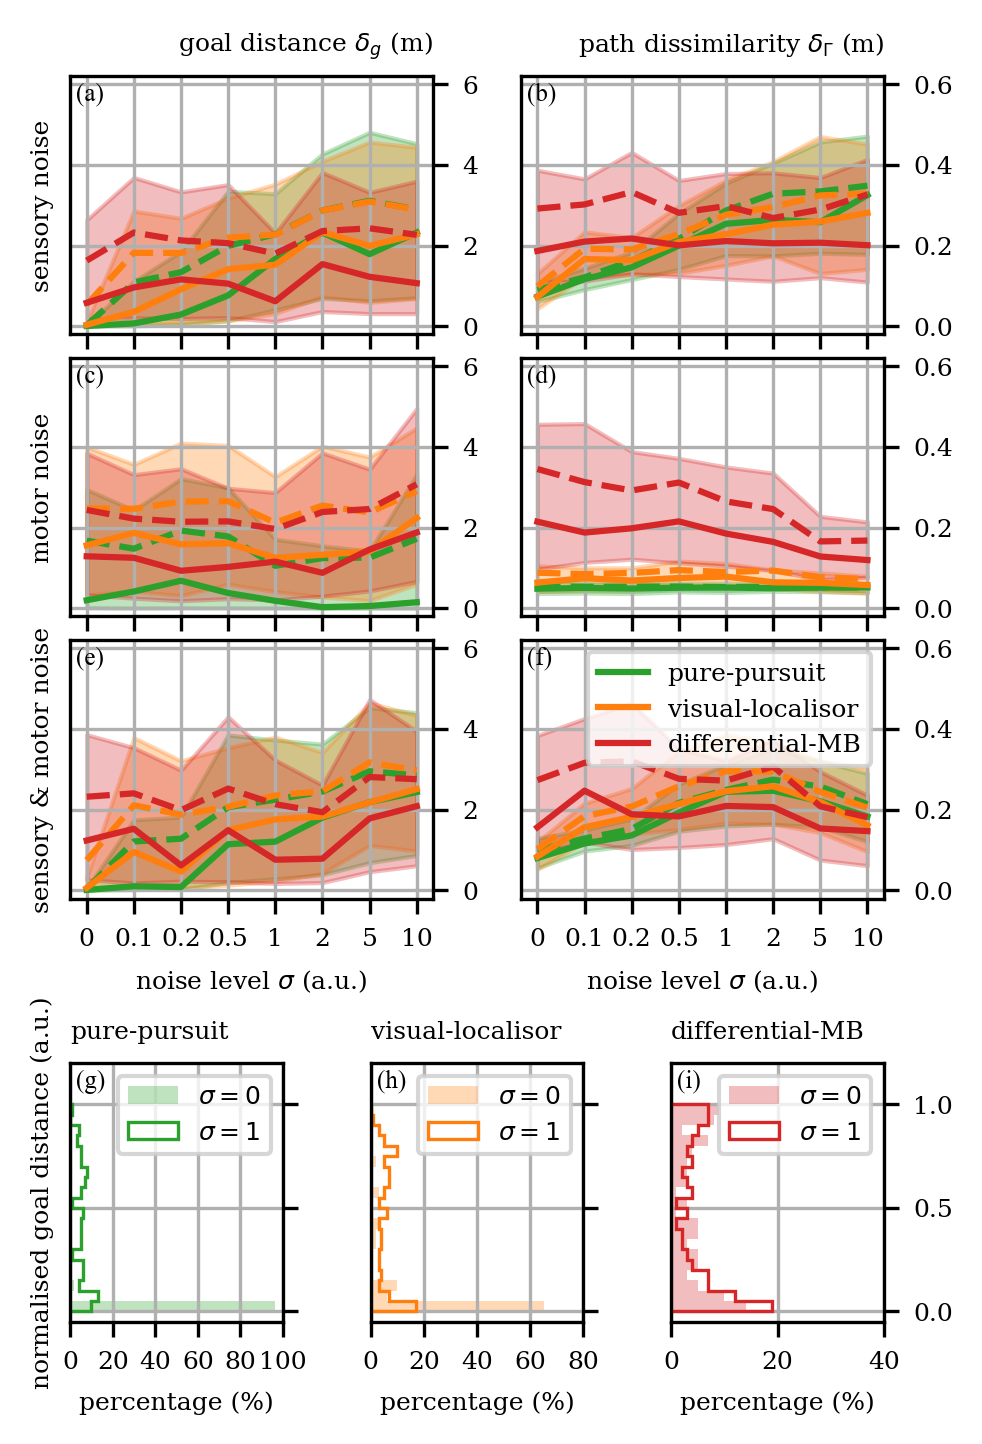

In [14]:
fig, axs = plt.subplot_mosaic('''
                                aaaaa.bbbbb
                                aaaaa.bbbbb
                                ccccc.ddddd
                                ccccc.ddddd
                                eeeee.fffff
                                eeeee.fffff
                                ...........
                                ggg.hhh.iii
                                ggg.hhh.iii''', figsize=(3.5, 5.5), dpi=300, layout='constrained')

axes = np.array([[axs[ak] for ak in ac] for ac in ('ab', 'cd', 'ef')])

for axcol, datafile_randomroute in zip(axes, ['sensor_noisefreetrain_robustness_3in1_randomroute.npy',
                                                 'motor_robustness_3in1_randomroute.npy',
                                                 'noise_noisefreetrain_robustness_3in1_randomroute.npy']):
    data_randomroute = np.load(os.path.join('records/data_randomroute', datafile_randomroute), allow_pickle=True)[()]
    bx, cx = axcol

    for xoffset, model_name, color in zip(np.arange(n_model) - n_model / 2 + 0.5, ls_model_name, ls_color):        
        area_success, min_dist2goal, dsim_test2train, n_reach = [data_randomroute[key][model_name] for key in ('area_success', 'min_dist2goal', 'dsim_test2train', 'noise1_reach')]

        for bc, data in zip((bx, cx), (min_dist2goal, dsim_test2train)):
            quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
            avg = np.nanmean(data, axis=1)
            bc.plot(np.arange(n_condition), avg, color=color, ls='dashed')
            bc.plot(np.arange(n_condition), quant[1], color=color, label=model_name)
            bc.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)

for ax in axes.flatten():
    ax.grid()
    ax.set_xticks(np.arange(n_condition), [])
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
    ax.yaxis.tick_right()
    
    
for ax in axes[-1]:
    ax.set_xlabel(r'noise level $\sigma$ (a.u.)', fontsize=6)
    ax.set_xticklabels(ls_value)

            
for ax, tt in zip(axes.T[0], ('sensory noise', 'motor noise', 'sensory & motor noise')):
    ax.set_ylabel(tt, fontsize=6)
    
for ax, yl in zip(axes[0], ('goal distance $\delta_g$ (m)', 'path dissimilarity $\delta_\Gamma$ (m)')):
    ax.set_title(yl, fontsize=6, loc='right')
    
for ax in axes.T[0]:
    ax.set_ylim(-0.2, 6.2)
for ax in axes.T[1]:
    ax.set_ylim(-0.02, 0.62)
axs['f'].legend(loc=1, fontsize=6)


data_trainroute = {'len': [], 'dist': []}

######
axes2 = [axs[ak] for ak in 'ghi']
for model_name, color, ax in zip(ls_model_name, ls_color, axes2):
    for vidx, ht, ls, al in zip([0, 4], ('stepfilled', 'step'), ('solid', 'solid'), (0.3, 1)):
        noise = ls_value[vidx]
        label = r'$\sigma={}$'.format(noise)
        
        path_train = data_path[model_name]['train'][vidx]
        dist_start2goal = np.linalg.norm(path_train[:,:,-1] - path_train[:, :, 0], axis=1)
        normindist = np.divide(data_min_dist2goal[model_name][vidx], dist_start2goal)
        ax.hist(normindist, label=label,
            bins=20, #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], #200, 
            range=(0, 1),
            color=color, orientation='horizontal', histtype=ht, alpha=al, lw=0.8) 
        
        if model_name == 'differential-MB' and noise == 0:
            nmd_idx = np.argsort(normindist)
            dMBnmd = normindist
            dMBtrainlen = np.sum(np.linalg.norm(path_train[:,:,1:] - path_train[:, :, :-1], axis=1), axis=1)   
            dMBtraindist = np.linalg.norm(path_train[:,:,0] - path_train[:, :, -1], axis=1)
            
        trainlen = np.sum(np.linalg.norm(path_train[:,:,1:] - path_train[:, :, :-1], axis=1), axis=1)   
        traindist = np.linalg.norm(path_train[:,:,0] - path_train[:, :, -1], axis=1)
        data_trainroute['len'].append(trainlen)
        data_trainroute['dist'].append(traindist)
            
    ax.set_title(model_name, fontsize=6, loc='left')

    
    
for ax in axes2:
    ax.grid()
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
    ax.yaxis.tick_right()
    ax.legend(loc=1, fontsize=6)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel('percentage (%)', fontsize=6)
    ax.set_ylim(top=1.2)
    
axes2[0].set_ylabel('normalised goal distance (a.u.)', fontsize=6)

axes2[0].set_xlim(right=100)
axes2[1].set_xlim(right=80)
axes2[2].set_xlim(right=40)

axes2[0].set_xticks(np.linspace(0, 100, 6))
axes2[1].set_xticks(np.linspace(0, 80, 5))

for ak in 'gh':
    axs[ak].set_yticklabels([])\
    
    
    
import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(0.02, -0.02, fig.dpi_scale_trans)
for label, ax in axs.items():
    ax.text(0.0, 1.0, '({})'.format(label), transform=ax.transAxes + trans,
            fontsize=6, verticalalignment='top', fontfamily='serif')

In [15]:
data_trainroute = {'len': [], 'dist': []}

for vidx in range(n_condition):
    for model_name in ls_model_name:
        noise = ls_value[vidx]
        label = r'$\sigma={}$'.format(noise)
        
        path_train = data_path[model_name]['train'][vidx]
        dist_start2goal = np.linalg.norm(path_train[:,:,-1] - path_train[:, :, 0], axis=1)
        normindist = np.divide(data_min_dist2goal[model_name][vidx], dist_start2goal)
        

            
    trainlen = np.sum(np.linalg.norm(path_train[:,:,1:] - path_train[:, :, :-1], axis=1), axis=1)   
    traindist = np.linalg.norm(path_train[:,:,0] - path_train[:, :, -1], axis=1)
    data_trainroute['len'].append(trainlen)
    data_trainroute['dist'].append(traindist)
            


183


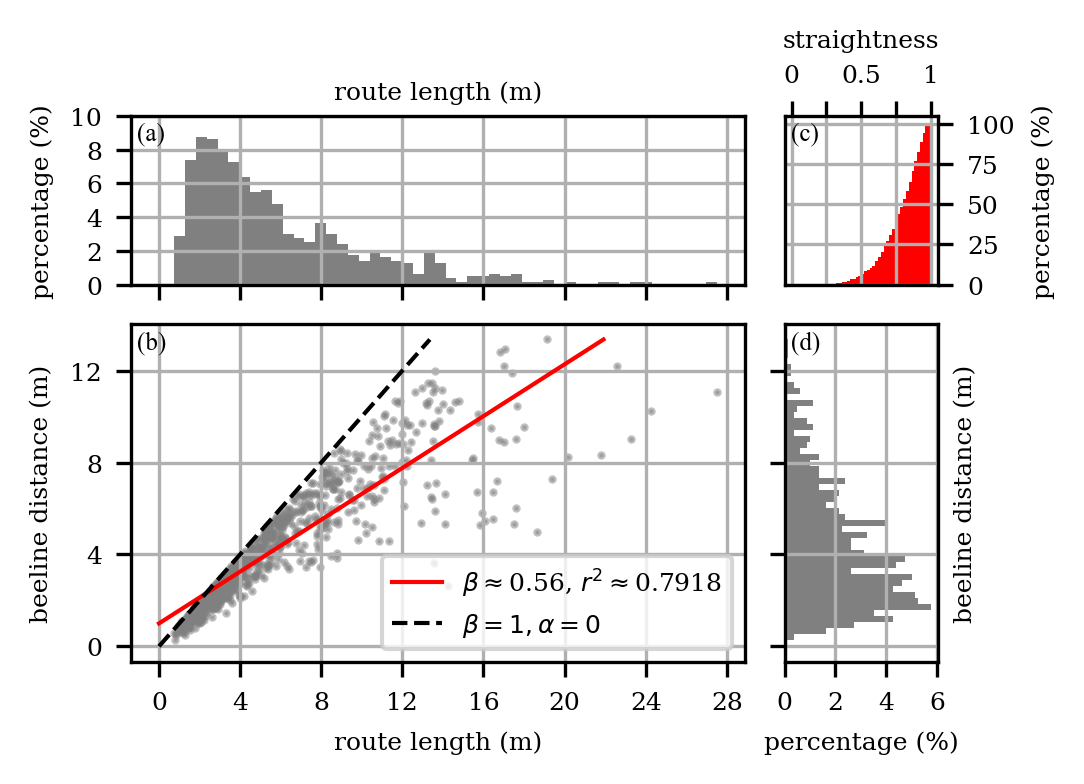

In [16]:
fig, axes = plt.subplot_mosaic('''ccccd
                                  aaaab
                                  aaaab''', figsize=(3.5, 2.5), dpi=300, layout='constrained')

x, y = np.ravel(data_trainroute['len']), np.ravel(data_trainroute['dist'])
res = stats.linregress(x, y)
axes['a'].scatter(x, y, s=1, alpha=0.5, color='grey')
ym = np.max(y)
x_ym = (ym - res.intercept) / res.slope
axes['a'].plot([0, x_ym], [res.intercept, ym], 'r', lw=1, label=r'$\beta\approx${:.2f}, $r^2\approx${:.4f}'.format(res.slope, res.rvalue**2))
axes['a'].plot([0, ym], [0, ym], 'k', ls='dashed', lw=1, label=r'$\beta=1, \alpha=0$')


nbin = 50

axes['b'].hist(y, bins=nbin, color='grey', orientation='horizontal')
axes['b'].yaxis.set_label_position('right') 
axes['b'].set_yticklabels([])

axes['c'].hist(x, bins=nbin, color='grey', orientation='vertical')
axes['c'].xaxis.set_label_position('top') 
axes['c'].set_xticklabels([])

stt = y / x
dh = axes['d'].hist(stt, bins=nbin, range=(0,1), cumulative=True, color='r')
print(np.count_nonzero(stt >= .9))

axes['d'].xaxis.tick_top()
axes['d'].yaxis.tick_right()
axes['d'].xaxis.set_label_position('top') 
axes['d'].yaxis.set_label_position('right') 

# lo, md, hi = np.quantile(stt, (0.25, 0.5, 0.75))
# axes['d'].axvline(md, lw=1, color='k')
# axes['d'].axvline(lo, lw=1, color='k', ls='dotted')
# axes['d'].axvline(hi, lw=1, color='k', ls='dotted')



axes['b'].set_ylim(axes['a'].get_ylim())
axes['c'].set_xlim(axes['a'].get_xlim())

for ak in 'ab':
    axes[ak].set_yticks(np.arange(0, 12.1, 4))
    axes[ak].set_ylabel('beeline distance (m)', fontsize=6)
for ak in 'ac':
    axes[ak].set_xticks(np.arange(0, 28.1, 4))
    axes[ak].set_xlabel('route length (m)', fontsize=6)

axes['b'].set_xticks(np.arange(0, 0.061, 0.02) * 800, [0, 2, 4, 6])
axes['c'].set_yticks(np.arange(0, 0.11, 0.02) * 800, [0, 2, 4, 6, 8, 10])
axes['d'].set_xticks(np.arange(0, 1.01, 0.25), [0, '', 0.5, '', 1])
axes['d'].set_yticks(np.arange(0, 1.01, 0.25) * 800, np.arange(0, 101, 25))
# axes['d'].set_xlim(0.5, 1)

axes['a'].legend(fontsize=6)
axes['b'].set_xlabel('percentage (%)', fontsize=6)
for ak in 'cd':
    axes[ak].set_ylabel('percentage (%)', fontsize=6)
    
axes['d'].set_xlabel('straightness', fontsize=6)


import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(0.02, -0.02, fig.dpi_scale_trans)

for label, ax in zip('acbd', axes.values()):
    ax.grid()
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)

    ax.text(0.0, 1.0, '({})'.format(label), transform=ax.transAxes + trans,
            fontsize=6, verticalalignment='top', fontfamily='serif')

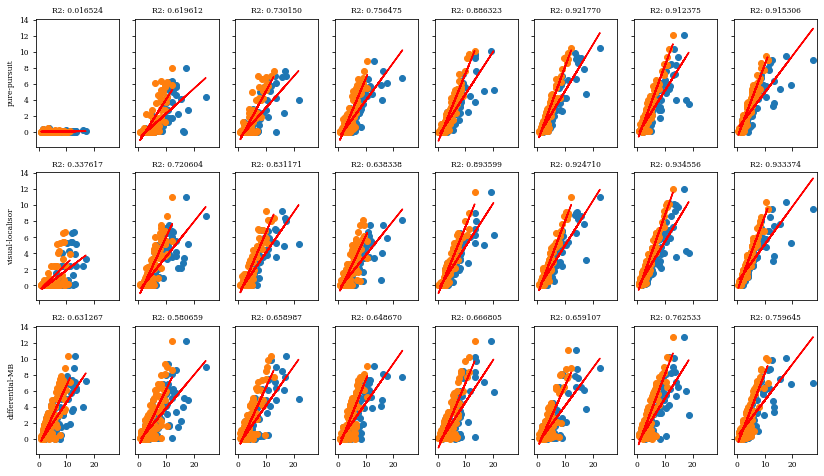

In [17]:
fig, axes = plt.subplots(3, 8, figsize=(14, 8), sharex=True, sharey=True)

regv = {'R2': {}, 'slope': {}}
for axrow, model_name in zip(axes, ls_model_name):
    axrow[0].set_ylabel(model_name)
    regv['R2'][model_name] = {'len': [], 'dist': []}
    regv['slope'][model_name] = {'len': [], 'dist': []}
    for ax, x1, x2, y in zip(axrow, data_trainroute['len'], data_trainroute['dist'], data_min_dist2goal[model_name]):
        for x, key in zip((x1, x2), ('len', 'dist')):
            res = stats.linregress(x, y)
            vR2 = res.rvalue ** 2
            vSl = res.slope
            ax.set_title(f"R2: {vR2:.6f}")
            ax.scatter(x, y)
            ax.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

            regv['R2'][model_name][key].append(vR2)
            regv['slope'][model_name][key].append(vSl)

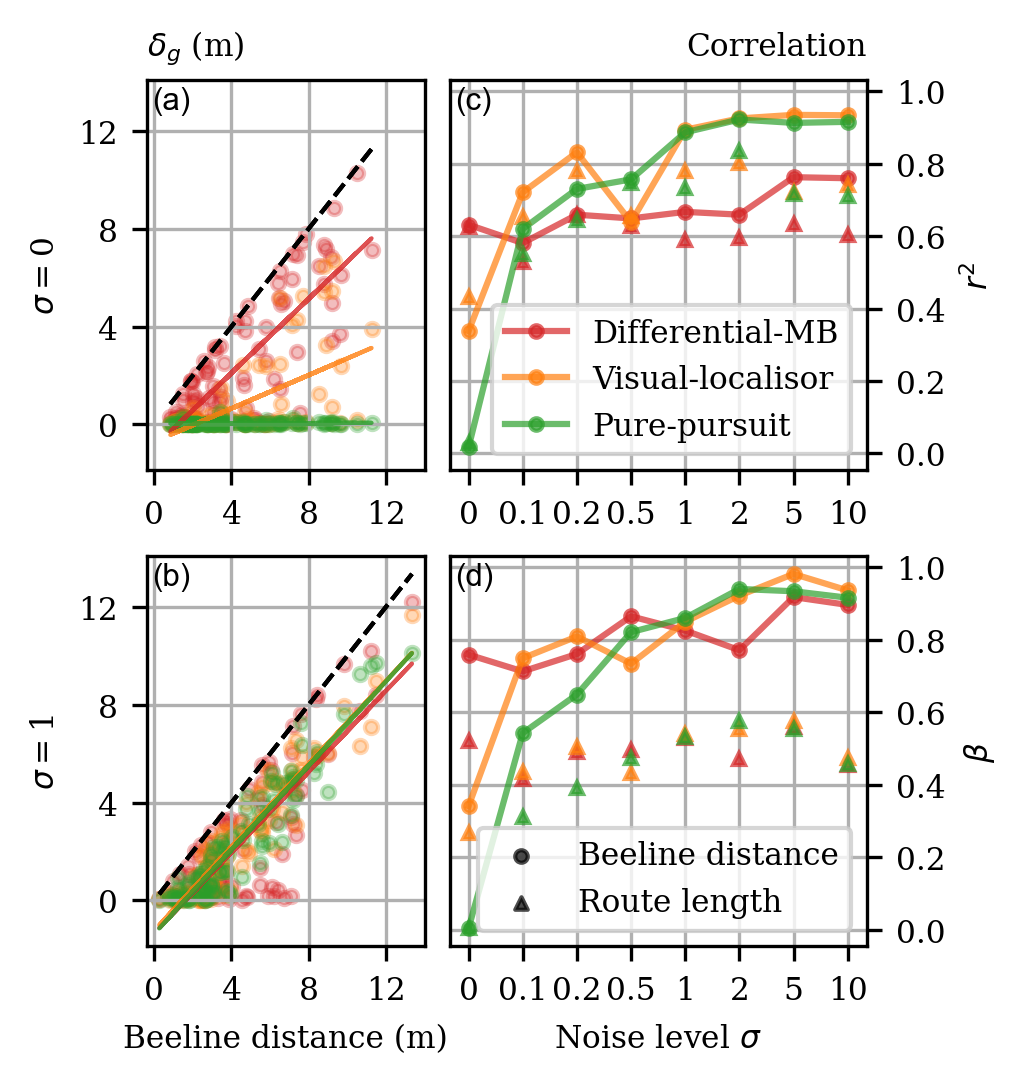

In [59]:
fig, axs = plt.subplot_mosaic('''
                                aaccc
                                bbddd
                                ''', figsize=(figw2, 3.5), dpi=300, layout='constrained')
axes = np.array([[axs['a'], axs['c']], [axs['b'], axs['d']]])

for model_name, color, mn in zip(np.flip(ls_model_name), np.flip(ls_color), ['Differential-MB', 'Visual-localisor', 'Pure-pursuit']):
    for ari, idx in zip((0, 1), (0, 4)):
        x, y = data_trainroute['dist'][idx], data_min_dist2goal[model_name][idx]
        axes[ari, 0].scatter(x, y, color=color, s=10, alpha=0.3)
        res = stats.linregress(x, y)
        vR2 = res.rvalue ** 2
        vSl = res.slope
        axes[ari, 0].plot(x, res.intercept + res.slope*x, color, lw=1, alpha=0.8)
        axes[ari, 0].plot([np.min(x), np.max(x)], [np.min(x), np.max(x)], c='k', ls='dashed', lw=1)
    
    axes[0, 1].plot(np.arange(n_condition), regv['R2'][model_name]['dist'], ms=3, marker='o', color=color, alpha=0.7, label=mn)
    axes[0, 1].plot(np.arange(n_condition), regv['R2'][model_name]['len'], ms=3, marker='^', color=color, alpha=0.7, ls='none')

    
    axes[1, 1].plot(np.arange(n_condition), regv['slope'][model_name]['dist'], color=color, ms=3, marker='o', alpha=0.7)
    axes[1, 1].plot(np.arange(n_condition), regv['slope'][model_name]['len'], color=color, ms=3, marker='^', ls='none', alpha=0.7)
    
    

axes[1, 0].sharex(axes[0, 0])
axes[1, 0].sharey(axes[0, 0])
axes[1, 1].sharex(axes[0, 1])
axes[1, 1].sharey(axes[0, 1])
axes[0, 0].set_xticks(np.arange(0, 13, 4))
axes[0, 0].set_yticks(np.arange(0, 13, 4))

# axes[0, 1].set_yticks(np.arange(0, 0.91, 0.3))
axes[0, 1].set_xticks(np.arange(n_condition), ls_value)

for ax, tit, loc in zip(axes[0], ('$\delta_g$ (m)', 'Correlation'), ('left', 'right')):
    ax.set_title(tit,  loc=loc)
    
for ax, tit in zip(axes.T[1], (r'$r^2$', r'$\beta$')):
    ax.set_ylabel(tit)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right') 
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    
for ax, tit in zip(axes.T[0], (0, 1)):
    ax.set_ylabel(r'$\sigma=${}'.format(tit))

for ax, xl in zip(axes[1], ('Beeline distance (m)', 'Noise level $\sigma$')):
    ax.set_xlabel(xl)
    

    
axes[1, 1].scatter([], [], color='k', s=9, alpha=0.7, marker='o', label='Beeline distance')
axes[1, 1].scatter([], [], color='k', s=9, alpha=0.7, marker='^', label='Route length')
    
for ax in axes.T[1]:
    ax.legend()
    
for label, ax in zip('acbd', axes.flatten()):
    ax.grid()
    
complete_figure(fig, axes, 'acbd')

# random route data may need further analysis!!!!

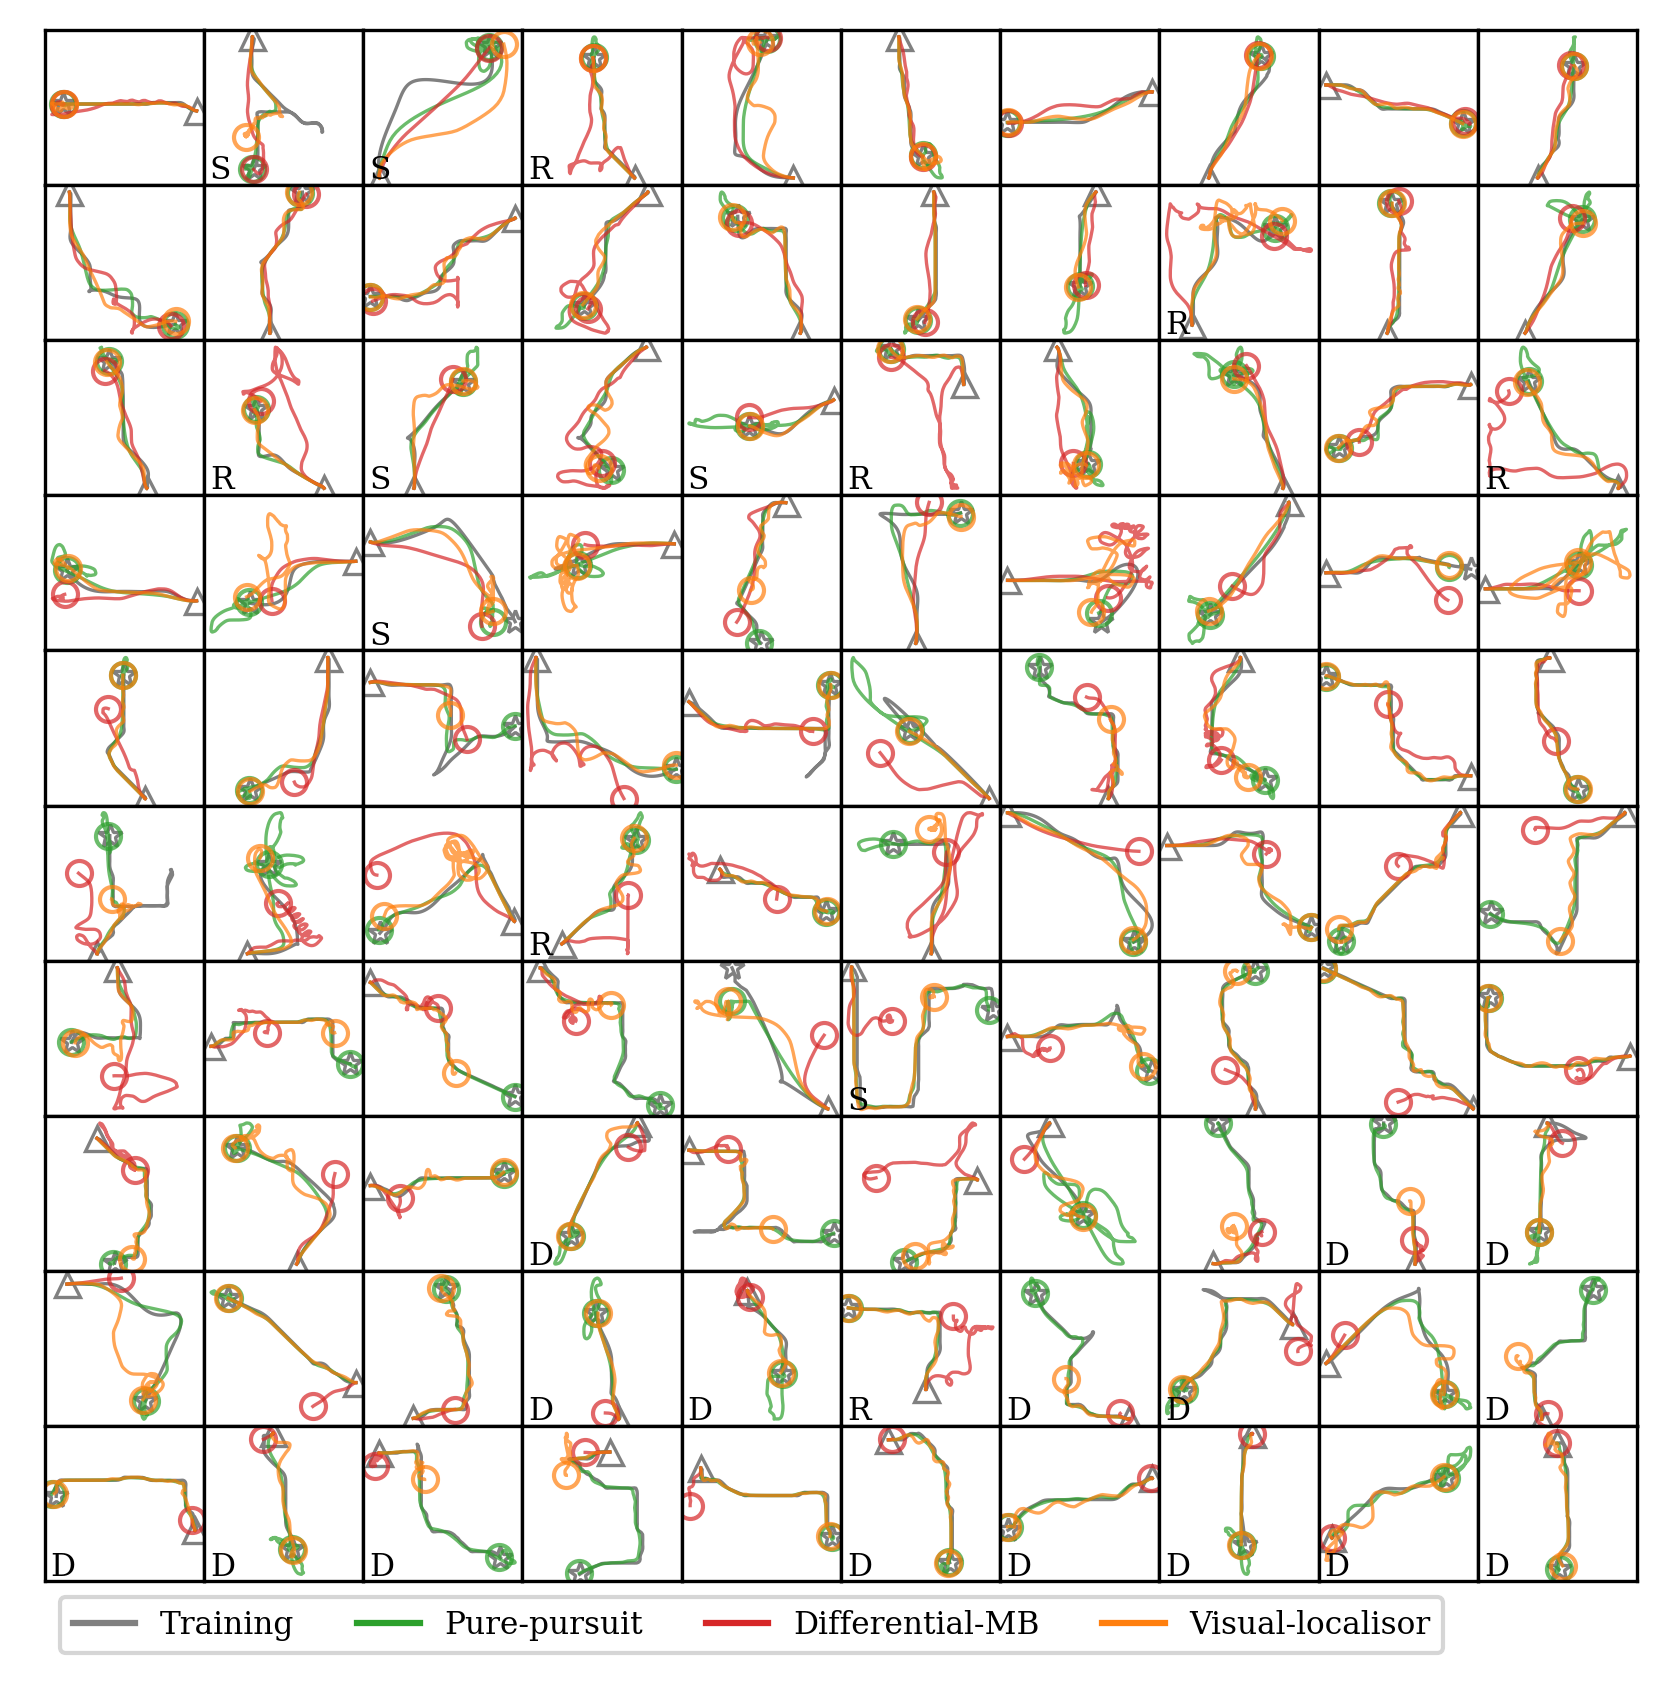

In [66]:
fig, axes = plt.subplots(10, 10, figsize=(figw1, figw1), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
lw = 0.8

cond_idx = 0
for trial_idx, ax in zip(nmd_idx, axes.flatten()):
    ax.plot(*data_path['pure-pursuit']['train'][cond_idx, trial_idx], color='grey', lw=lw)
    ax.plot(*data_path['pure-pursuit']['train'][cond_idx, trial_idx, :, 0], 
            mfc='none', color='grey', marker='^', markeredgewidth=lw)
    ax.plot(*data_path['pure-pursuit']['train'][cond_idx, trial_idx, :, -1],
            mfc='none', color='grey', marker='*', markeredgewidth=lw)
    for model_name, color in zip(np.array(ls_model_name)[[0, 2, 1]], np.array(ls_color)[[0, 2, 1]]):
#         ax.plot(*data_path[model_name]['test'][cond_idx, trial_idx], ls='dotted', color=color, alpha=0.5, lw=lw)
        ax.plot(*data_path[model_name]['test_trunc'][cond_idx, trial_idx], 
                ls='solid', color=color, alpha=0.7, lw=lw)
        ax.plot(*data_path[model_name]['test_trunc'][cond_idx, trial_idx, :, data_time_min_dist2goal[model_name][cond_idx, trial_idx]], 
                ls='solid', color=color, alpha=0.7, marker='o', mfc='none', lw=lw)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable="datalim")
    
axes[-1, 0].plot([], [], c='grey', label='Training')
for model_name, color in zip(['Pure-pursuit', 'Differential-MB', 'Visual-localisor'], np.array(ls_color)[[0, 2, 1]]):
    axes[-1, 0].plot([], [], c=color, label=model_name)
axes[-1, 0].legend(ncol=4, loc='upper left', bbox_to_anchor=(0., 0))


bls = np.full(100, '')
bls[[0, 5, 6, 28, 51, 58, 69, 72, 73, 77, 86, 87, 94, 96, 97, 98]] = 'D'
bls[[8, 18, 20, 34, 41, 82, 84]] = 'R'
bls[[17, 42, 49, 60, 74, 93]] = 'S'
import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(0.02, 0.1, fig.dpi_scale_trans)
for ax, bl in zip(axes.flatten(), bls[nmd_idx]):
    ax.text(0.0, 0.0, bl, transform=ax.transAxes + trans,
            verticalalignment='top')

R-squared: 0.164905


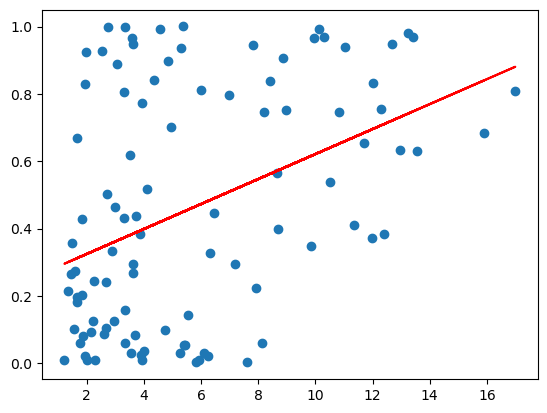

In [53]:
from scipy import stats
x, y = data_trainroute['len'][0], dMBnmd #dMBnmd
res = stats.linregress(x, y)
print(f"R-squared: {res.rvalue**2:.6f}")
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

R-squared: 0.624177


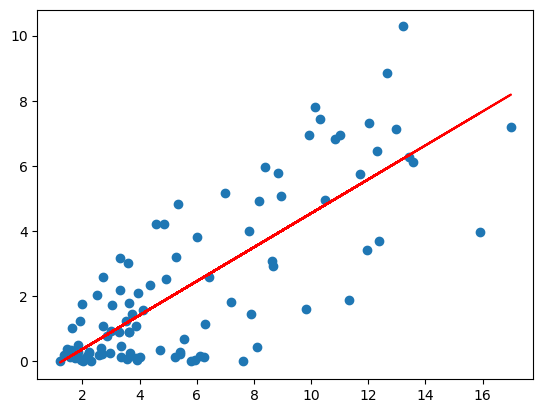

In [25]:
from scipy import stats
x, y = data_trainroute['len'][0], data_min_dist2goal['differential-MB'][0] #dMBnmd
res = stats.linregress(x, y)
print(f"R-squared: {res.rvalue**2:.6f}")
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

R-squared: 0.017358


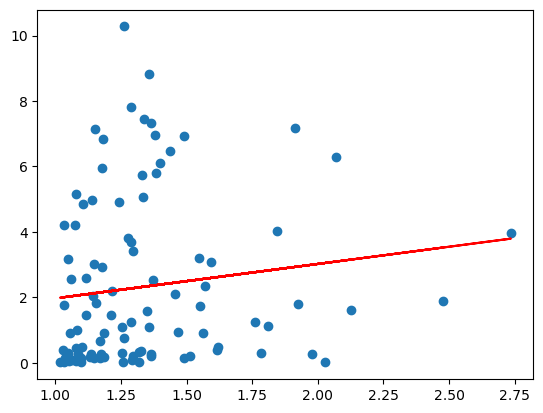

In [13]:
from scipy import stats
x, y = dMBtrainlen / dMBtraindist, data_min_dist2goal['differential-MB'][0]# dMBnmd
res = stats.linregress(x, y)
print(f"R-squared: {res.rvalue**2:.6f}")
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

In [17]:
data_dir = '/home/yihelu/miniconda3/envs/igibson/lib/python3.8/site-packages/igibson/yihe/records/noise_noisefreetrain_robustness_3in1_randomroute/noise0'

In [18]:
t_min = data_dist_testtrunc2goal['differential-MB'][0]

In [19]:
dir_scene = '/home/yihelu/miniconda3/envs/igibson/lib/python3.8/site-packages/igibson/data/ig_dataset/scenes/'
dir_floor = 'layout/floor_trav_no_door_0.png'

In [28]:
def scale_xylim(xl, yl, factor):
    new_xylim = []
    for lo, hi in (xl, yl):
        mid = (hi + lo) / 2
        newhalfw = (hi - lo) / 2 * factor
        new_lo, new_hi = mid - newhalfw, mid + newhalfw
        new_xylim.append([new_lo, new_hi])
    return new_xylim

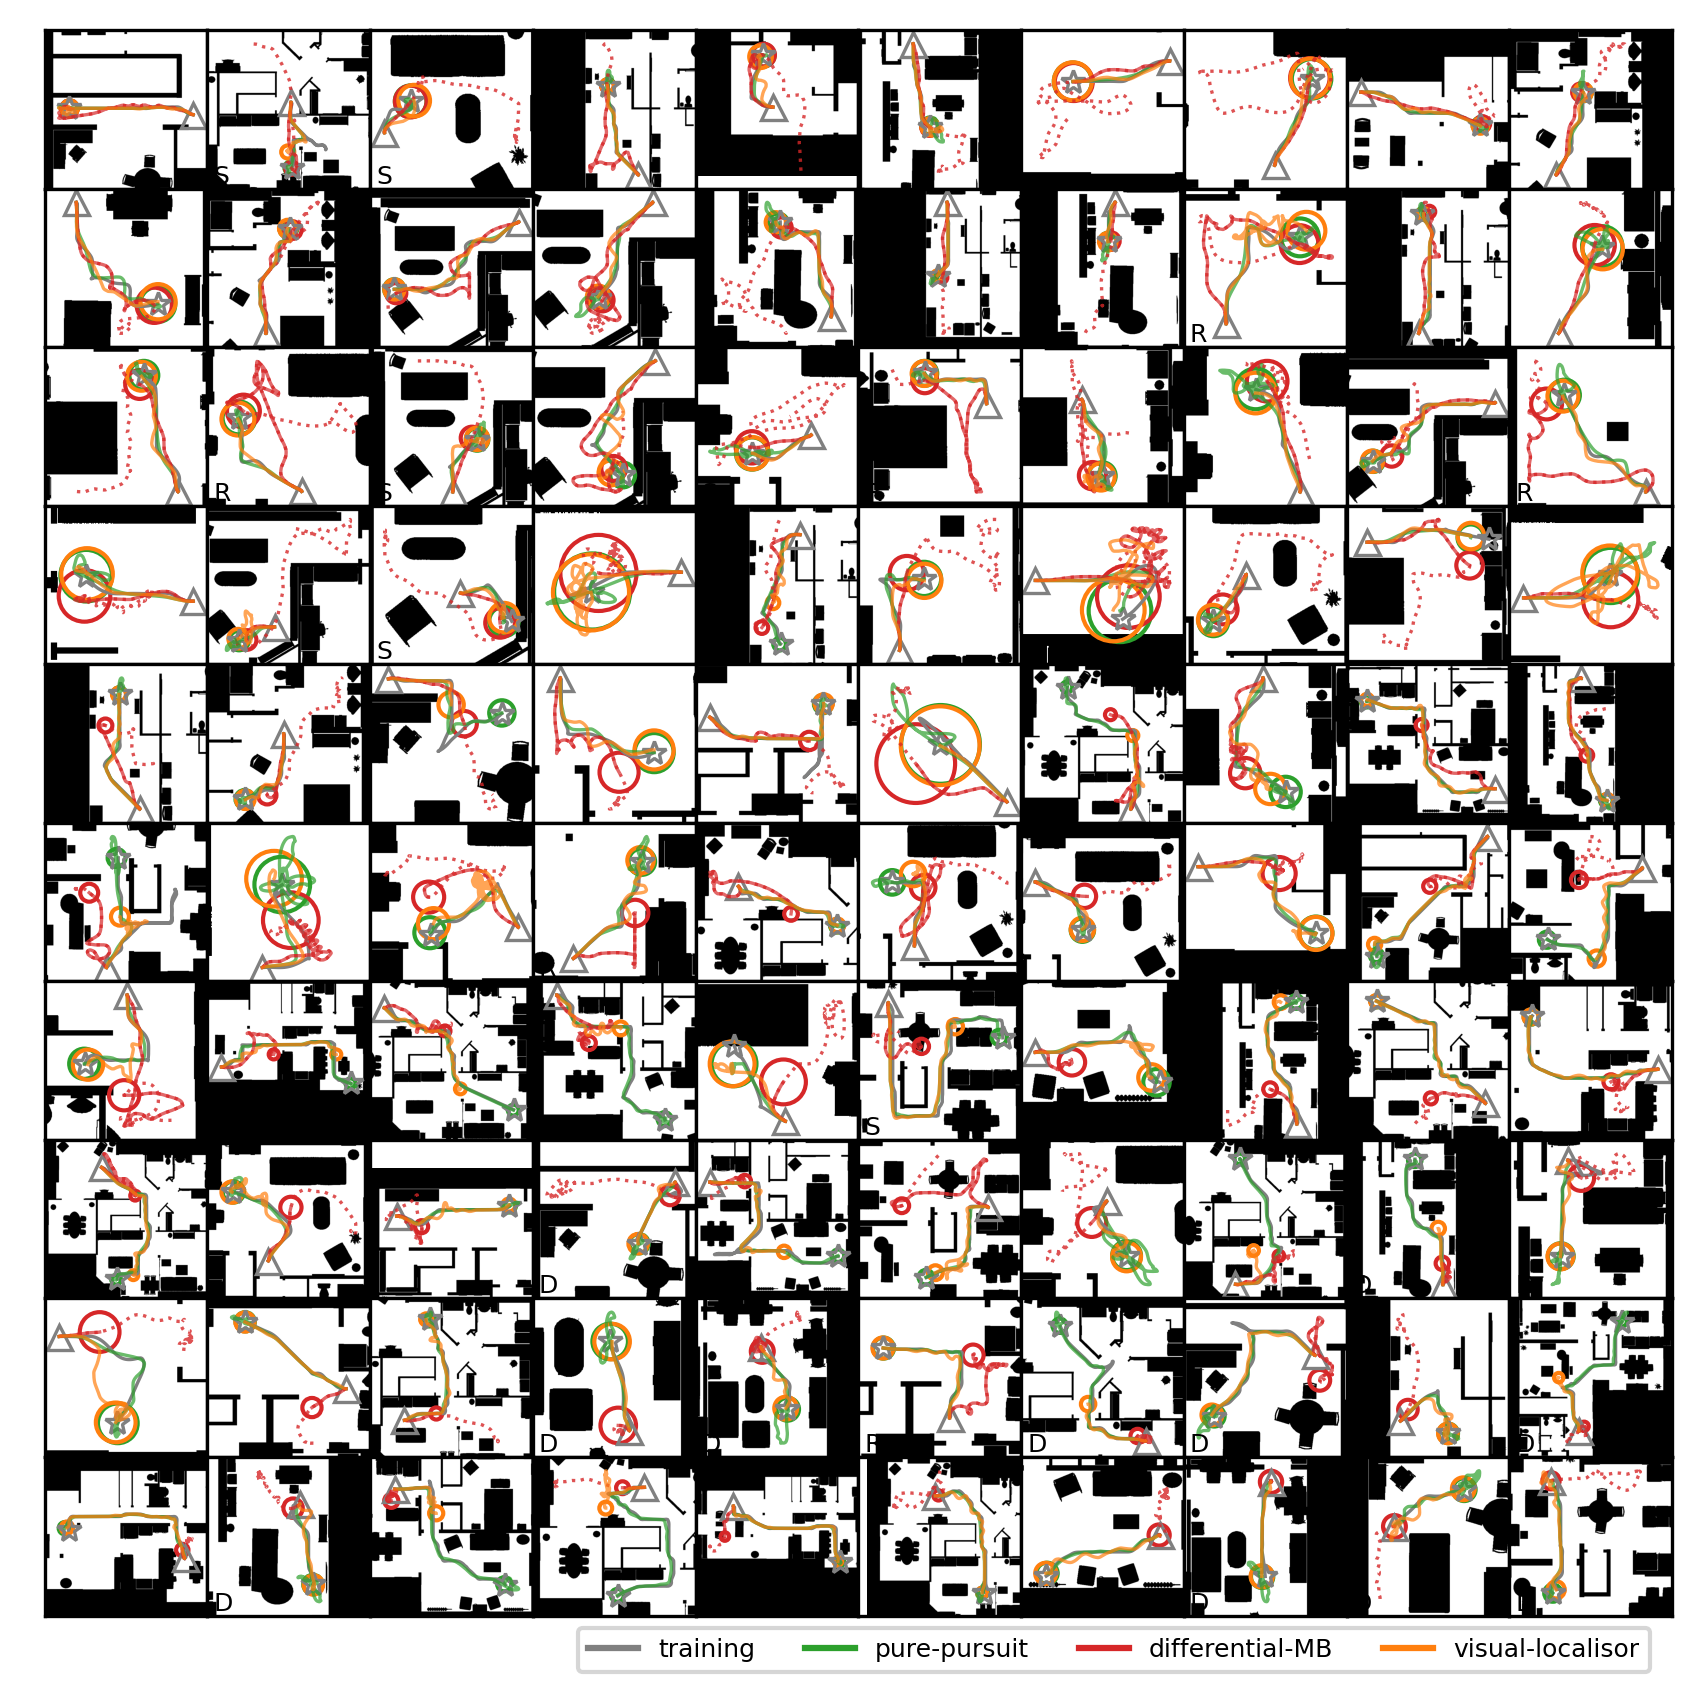

In [36]:
fig, axes = plt.subplots(10, 10, figsize=(7, 7), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
lw = 0.8

cond_idx = 0
for trial_idx, subdir, ax in zip(nmd_idx, np.sort(os.listdir(data_dir))[nmd_idx], axes.flatten()):
    ax.plot(*data_path['pure-pursuit']['train'][cond_idx, trial_idx], color='grey', lw=lw)
    ax.plot(*data_path['pure-pursuit']['train'][cond_idx, trial_idx, :, 0], 
            mfc='none', color='grey', marker='^', markeredgewidth=lw)
    ax.plot(*data_path['pure-pursuit']['train'][cond_idx, trial_idx, :, -1],
            mfc='none', color='grey', marker='*', markeredgewidth=lw)
    for model_name, color in zip(np.array(ls_model_name)[[0, 2, 1]], np.array(ls_color)[[0, 2, 1]]):
        if model_name == 'differential-MB':
            ax.plot(*data_path[model_name]['test'][cond_idx, trial_idx], ls='dotted', color=color, alpha=0.8, lw=lw)
        ax.plot(*data_path[model_name]['test_trunc'][cond_idx, trial_idx], 
                ls='solid', color=color, alpha=0.7, lw=lw)
        optimum = data_path[model_name]['test_trunc'][cond_idx, trial_idx, :, data_time_min_dist2goal[model_name][cond_idx, trial_idx]]
#         ax.plot(*data_path[model_name]['test_trunc'][cond_idx, trial_idx, :, data_time_min_dist2goal[model_name][cond_idx, trial_idx]], 
#                 ls='solid', color=color, alpha=0.7, marker='o', mfc='none', lw=lw)
        circle = plt.Circle(optimum, 0.372, color=color, fill=False)
        ax.add_patch(circle)
            
    ax.set_xticks([])
    ax.set_yticks([])
    
    ## floor plan
    xl, yl = ax.get_xlim(), ax.get_ylim()
    
    raw_data = np.load(os.path.join(data_dir, subdir, 'Freight_test_0_lamb_record.npz'))
    scene_name = str(raw_data['scene_name'])
    floorplan = os.path.join(dir_scene, scene_name, dir_floor)
    draw_floorplan(ax, floorplan, 0.01)
    
    newxl, newyl = scale_xylim(xl, yl, 1.1)
    ax.set_xlim(newxl)
    ax.set_ylim(newyl)
    ##
    
    ax.set_aspect('equal', adjustable="datalim")
    
axes[-1, 3].plot([], [], c='grey', label='training')
for model_name, color in zip(np.array(ls_model_name)[[0, 2, 1]], np.array(ls_color)[[0, 2, 1]]):
    axes[-1, 3].plot([], [], c=color, label=model_name)
axes[-1, 3].legend(fontsize=6, ncol=4, loc='upper left', bbox_to_anchor=(0.2, 0))


bls = np.full(100, '')
bls[[0, 5, 6, 28, 51, 58, 69, 72, 73, 77, 86, 87, 94, 96, 97, 98]] = 'D'
bls[[8, 18, 20, 34, 41, 82, 84]] = 'R'
bls[[17, 42, 49, 60, 74, 93]] = 'S'
import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(0.02, 0.08, fig.dpi_scale_trans)
for ax, bl in zip(axes.flatten(), bls[nmd_idx]):
    ax.text(0.0, 0.0, bl, transform=ax.transAxes + trans,
            fontsize=6, verticalalignment='top')

fig, ax = plt.subplots(figsize=(8, 5))
for idx, (key, val) in enumerate(scene_count.items()):
    ax.scatter(np.full_like(val, idx), val)
ax.set_xticks(np.arange(len(scene_count.keys())), scene_count.keys(), rotation=90)